In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
curr_dir = os.getcwd()
dir_path = os.path.join(curr_dir , 'drive' , 'MyDrive','Codalab','Meme Classification Challenge','Tamil_troll_memes')
os.listdir(dir_path)

['training_img.zip', 'train_captions.csv', 'training_img']

In [ ]:
img_dir = os.path.join(dir_path , 'training_img','uploaded_tamil_memes')
print(f" No. of training images => {len(os.listdir(img_dir)) } ")

 No. of training images => 2300 


In [ ]:
import pandas as pd
df_path = os.path.join(dir_path,'train_captions.csv')
df = pd.read_csv(df_path)
df.sample(10)

,Unnamed: 0,imagename,captions
385,385,Not_troll_429.jpg,paarthu pala natkal aaiduchi... nalla irukkiyaka?
1443,1443,troll_1381.jpg,MEDIA CHANNELS NOW BE LIKE....... KOHLI 50 AD...
35,35,Not_troll_113.jpg,GOOD NIGHT FRIENDS!
805,805,Not_troll_807.jpg,indha kodumaiya naan yenga poi solluven...
1714,1764,troll_1671.jpg,IVANGALUKKU ENA AIDS IRUKA EPO PARU MUNJA MUDI...
442,442,Not_troll_480.jpg,ini biriyani keppa..
427,427,Not_troll_467.jpg,vunakku like produradhe perusu idhulla comment...
2007,2057,troll_1935.jpg,"saithi nallai""agninachathiram"" arambam eppa ma..."
75,75,Not_troll_15.jpg,appalam vithathukku padhila apollovula idly vi...
195,195,Not_troll_258.jpg,yenkutla vijay tv varadhuda... yennai vittur...


In [ ]:
def modify_tags(text):
    arr = text.rsplit('_',1)
    return arr[0]

In [ ]:
df.drop('Unnamed: 0' , axis = 1 , inplace = True)

In [ ]:
df['labels'] = df['imagename'].apply(modify_tags)

In [ ]:
df.sample(5)

,imagename,captions,labels
889,Not_troll_883.jpg,"indru mudhal ni ""bluewhale"" yendru anbodu al...",Not_troll
463,Not_troll_5.jpg,konjam adakki vasinga!!!,Not_troll
852,Not_troll_85.jpg,indha maadhiri yedhavadhu solli naamale maatik...,Not_troll
1758,troll_1710.jpg,#10YEARCHALLENGE... AAGA JAYALALITHA PADHAVI ...,troll
259,Not_troll_315.jpg,aiyoo.. mudiyala..,Not_troll


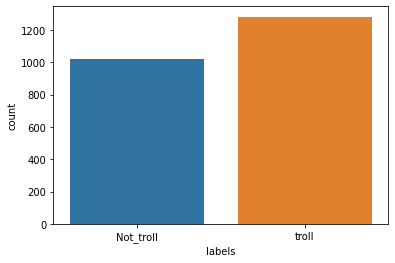

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x = df['labels'])

In [ ]:
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dropout , Dense, Input, concatenate , GlobalAveragePooling2D , AveragePooling2D , Flatten  
from tensorflow.keras.optimizers import RMSprop , Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
base_model = ResNet50( include_top = False, weights='imagenet', input_shape = (256,256,3) )
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
model.compile(loss = 'binary_crossentropy' , optimizer= 'adam' , metrics = ['acc'])

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

IMG_SHAPE = (256,256)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
                                          dataframe = df,
                                          directory = img_dir,
                                          x_col = "imagename",
                                          y_col = "labels",
                                          subset = "training",
                                          batch_size = 64,
                                          seed = 42,
                                          shuffle = True,
                                          class_mode = "binary",
                                          target_size = IMG_SHAPE
                          )

valid_generator = datagen.flow_from_dataframe(
                                          dataframe = df,
                                          directory = img_dir,
                                          x_col = "imagename",
                                          y_col = "labels",
                                          subset = "validation",
                                          batch_size = 64,
                                          seed = 42,
                                          shuffle = True,
                                          class_mode = "binary",
                                          target_size = IMG_SHAPE
                          )


Found 1725 validated image filenames belonging to 2 classes.
Found 575 validated image filenames belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
STEP_SIZE_TRAIN

26

In [ ]:
STEP_SIZE_VALID

8

In [ ]:
import time
file_path = './drive/MyDrive/Meme Classification Challenge/Models/pretrained_resnet50_model .{epoch:02d}-{val_loss:.2f}s '
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=file_path + str(time.asctime()) + '.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
history = model.fit( train_generator,
                     steps_per_epoch = STEP_SIZE_TRAIN,
                     validation_data=valid_generator,
                     validation_steps=STEP_SIZE_VALID,
                     epochs=10,
                     callbacks = [my_callbacks]
                    )

Epoch 1/10
 1/26 [>.............................] - ETA: 0s - loss: 1.3421 - acc: 0.2131WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 382s 15s/step - loss: 0.6215 - acc: 0.7297 - val_loss: 1.1762 - val_acc: 0.0117
Epoch 2/10
26/26 [==============================] - 16s 631ms/step - loss: 0.3568 - acc: 0.8736 - val_loss: 0.6959 - val_acc: 0.7539
Epoch 3/10
26/26 [==============================] - 16s 628ms/step - loss: 0.3133 - acc: 0.9055 - val_loss: 0.5280 - val_acc: 0.8438
Epoch 4/10
26/26 [==============================] - 16s 633ms/step - loss: 0.2827 - acc: 0.9169 - val_loss: 0.4494 - val_acc: 0.8730
Epoch 5/10
26/26 [==============================] - 17s 647ms/step - loss: 0.2687 - acc: 0.9205 - val_loss: 0.5723

In [ ]:
import time
t = time.asctime()
model.save('./drive/MyDrive/Codalab/Meme Classification Challenge/Models/Pretrained_resnet50_Model '+str(t))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./drive/MyDrive/Codalab/Meme Classification Challenge/Models/Pretrained_resnet50_Model Tue Dec 15 11:55:35 2020/assets


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) + 1)
plt.rcParams['figure.figsize'] = [14,10]

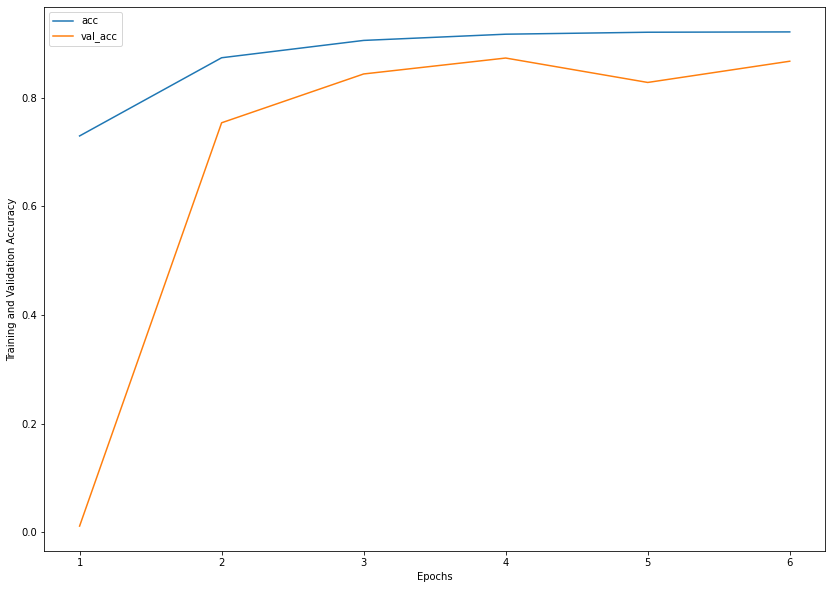

In [ ]:
plt.plot(epochs , acc)
plt.plot(epochs , val_acc)
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(['acc' , 'val_acc'])

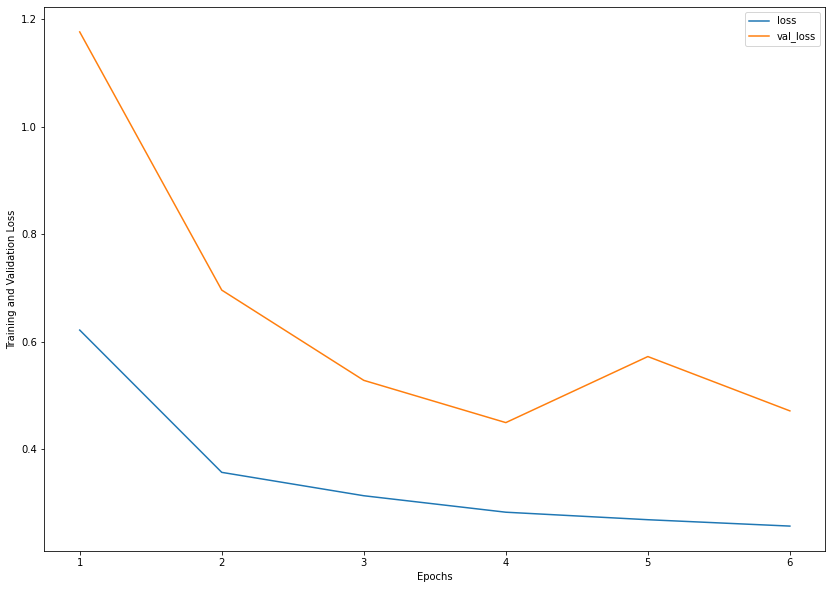

In [ ]:
plt.plot(epochs , loss)
plt.plot(epochs , val_loss)
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend(['loss','val_loss'])